In [1]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [2]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets.crsp_monthly import CRSPMonthly
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load dataset
df = CRSPMonthly(start_date=date(1995, 7, 31), end_date=date(2024, 12, 31)).load_all().select(["permno", "ticker", "date", "shrout", "prc", "ret"])

df

permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10001,"""EWST""",1995-07-31,2254.0,8.25,0.0
10001,"""EWST""",1995-08-31,2254.0,-8.0,-0.030303
10001,"""EWST""",1995-09-29,2280.0,8.25,0.04375
10001,"""EWST""",1995-10-31,2280.0,8.0,-0.030303
10001,"""EWST""",1995-11-30,2280.0,8.75,0.09375
…,…,…,…,…,…
93436,"""TSLA""",2024-07-31,3.19464e6,232.07001,0.172781
93436,"""TSLA""",2024-08-30,3.19464e6,214.11,-0.077391
93436,"""TSLA""",2024-09-30,3.207e6,261.63,0.221942


In [4]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-12 to t-2
df = df.with_columns(pl.col("logret").rolling_sum(window_size=11, min_periods=11).over("permno").alias("mom"))

# Lag once, skip once
df = df.with_columns(pl.col("mom").shift(2).over("permno"))

df

permno,ticker,date,shrout,prc,ret,logret,mom
i64,str,date,f64,f64,f64,f64,f64
10001,"""EWST""",1995-07-31,2254.0,8.25,0.0,0.0,null
10001,"""EWST""",1995-08-31,2254.0,-8.0,-0.030303,-0.030772,null
10001,"""EWST""",1995-09-29,2280.0,8.25,0.04375,0.04282,null
10001,"""EWST""",1995-10-31,2280.0,8.0,-0.030303,-0.030772,null
10001,"""EWST""",1995-11-30,2280.0,8.75,0.09375,0.089612,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-07-31,3.19464e6,232.07001,0.172781,0.159378,-0.385232
93436,"""TSLA""",2024-08-30,3.19464e6,214.11,-0.077391,-0.08055,-0.301196
93436,"""TSLA""",2024-09-30,3.207e6,261.63,0.221942,0.200441,-0.10623


In [5]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10001,"""EWST""",1996-07-31,2321.0,-8.1875,0.023438,0.023168,0.077599,8.0
10001,"""EWST""",1996-10-31,2346.0,-8.5,-0.028571,-0.028987,0.063992,8.75
10001,"""EWST""",1996-12-31,2357.0,8.125,-0.059429,-0.061268,0.01708,8.75
10001,"""EWST""",1997-01-31,2357.0,8.625,0.061539,0.05972,-0.033535,8.125
10001,"""EWST""",1997-02-28,2357.0,8.625,0.0,0.0,-0.067774,8.625
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-07-31,3.19464e6,232.07001,0.172781,0.159378,-0.385232,197.88
93436,"""TSLA""",2024-08-30,3.19464e6,214.11,-0.077391,-0.08055,-0.301196,232.07001
93436,"""TSLA""",2024-09-30,3.207e6,261.63,0.221942,0.200441,-0.10623,214.11


In [6]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10001,"""EWST""",1996-07-31,2321.0,-8.1875,0.023438,0.023168,0.077599,8.0,"""2"""
10001,"""EWST""",1996-10-31,2346.0,-8.5,-0.028571,-0.028987,0.063992,8.75,"""4"""
10001,"""EWST""",1996-12-31,2357.0,8.125,-0.059429,-0.061268,0.01708,8.75,"""3"""
10001,"""EWST""",1997-01-31,2357.0,8.625,0.061539,0.05972,-0.033535,8.125,"""2"""
10001,"""EWST""",1997-02-28,2357.0,8.625,0.0,0.0,-0.067774,8.625,"""2"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-07-31,3.19464e6,232.07001,0.172781,0.159378,-0.385232,197.88,"""1"""
93436,"""TSLA""",2024-08-30,3.19464e6,214.11,-0.077391,-0.08055,-0.301196,232.07001,"""1"""
93436,"""TSLA""",2024-09-30,3.207e6,261.63,0.221942,0.200441,-0.10623,214.11,"""2"""


In [7]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-07-31,-0.101521,-0.068782,-0.056909,-0.049272,-0.055478,-0.056717,-0.058458,-0.06682,-0.104831,-0.150142
1996-08-30,0.040414,0.046979,0.045983,0.045103,0.041884,0.045035,0.043968,0.039704,0.06512,0.08181
1996-09-30,0.028197,0.024466,0.025931,0.038617,0.03589,0.031983,0.036899,0.030738,0.054886,0.075489
1996-10-31,-0.059488,-0.028673,-0.012068,0.008784,0.008831,0.008988,0.003488,0.002266,-0.007334,-0.025748
1996-11-29,0.067324,0.040696,0.033227,0.040346,0.048424,0.040615,0.050234,0.038838,0.024007,0.009966
…,…,…,…,…,…,…,…,…,…,…
2024-07-31,0.086795,0.077036,0.091228,0.090515,0.075519,0.0958,0.091478,0.087363,0.079988,0.078802
2024-08-30,-0.070355,-0.039988,-0.016379,-0.002646,-0.008633,0.002363,-0.001167,0.006537,-0.002847,0.02617
2024-09-30,0.008389,0.002256,0.013406,0.002366,0.009212,0.014281,0.000747,0.024012,0.003147,0.015529


In [8]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-07-31,-0.101521,-0.068782,-0.056909,-0.049272,-0.055478,-0.056717,-0.058458,-0.06682,-0.104831,-0.150142,-0.04862
1996-08-30,0.040414,0.046979,0.045983,0.045103,0.041884,0.045035,0.043968,0.039704,0.06512,0.08181,0.041396
1996-09-30,0.028197,0.024466,0.025931,0.038617,0.03589,0.031983,0.036899,0.030738,0.054886,0.075489,0.047293
1996-10-31,-0.059488,-0.028673,-0.012068,0.008784,0.008831,0.008988,0.003488,0.002266,-0.007334,-0.025748,0.03374
1996-11-29,0.067324,0.040696,0.033227,0.040346,0.048424,0.040615,0.050234,0.038838,0.024007,0.009966,-0.057358
…,…,…,…,…,…,…,…,…,…,…,…
2024-07-31,0.086795,0.077036,0.091228,0.090515,0.075519,0.0958,0.091478,0.087363,0.079988,0.078802,-0.007992
2024-08-30,-0.070355,-0.039988,-0.016379,-0.002646,-0.008633,0.002363,-0.001167,0.006537,-0.002847,0.02617,0.096525
2024-09-30,0.008389,0.002256,0.013406,0.002366,0.009212,0.014281,0.000747,0.024012,0.003147,0.015529,0.00714


In [9]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
1996-07-31,"""0""",-0.101521
1996-07-31,"""1""",-0.068782
1996-07-31,"""2""",-0.056909
1996-07-31,"""3""",-0.049272
1996-07-31,"""4""",-0.055478
…,…,…
2024-11-29,"""6""",0.103565
2024-11-29,"""7""",0.105179
2024-11-29,"""8""",0.113423


In [10]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(((pl.col("mean") * 12) / (pl.col("std") * np.sqrt(12))).cast(pl.Float64).alias("annualized_sharpe"))

# Tstat
result = result.with_columns((pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat"))

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Monthly results")
result

Monthly results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.002381,0.006753,0.008832,0.009565,0.010272,0.010596,0.011287,0.010791,0.012324,0.013139,0.010759
"""std""",0.087199,0.065561,0.057168,0.050945,0.047444,0.045235,0.045436,0.04821,0.055821,0.07662,0.067972
"""count""",341.0,341.0,341.0,341.0,341.0,341.0,341.0,341.0,341.0,341.0,341.0
"""annualized_sharpe""",0.094574,0.356799,0.535183,0.650415,0.750015,0.811464,0.86055,0.775392,0.76479,0.594044,0.548297
"""tstat""",0.504146,1.901998,2.852914,3.467188,3.998129,4.325695,4.587358,4.133402,4.07689,3.166686,2.922823


In [11]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
1996-07-31,"""0""",-0.101521,-0.107052,-10.705233
1996-07-31,"""1""",-0.068782,-0.071262,-7.12621
1996-07-31,"""2""",-0.056909,-0.058592,-5.859217
1996-07-31,"""3""",-0.049272,-0.050527,-5.052693
1996-07-31,"""4""",-0.055478,-0.057077,-5.707683
…,…,…,…,…
2024-11-29,"""6""",0.103565,0.098546,347.511159
2024-11-29,"""7""",0.105179,0.100008,326.342386
2024-11-29,"""8""",0.113423,0.107439,365.142392


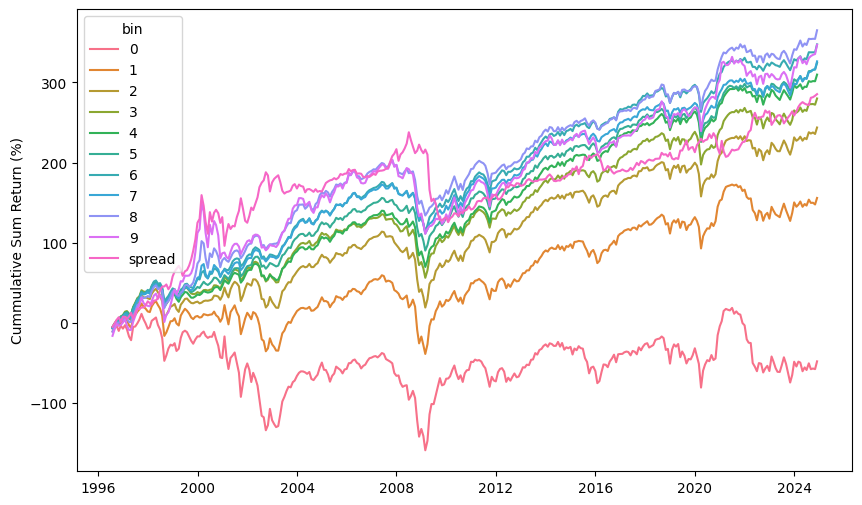

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

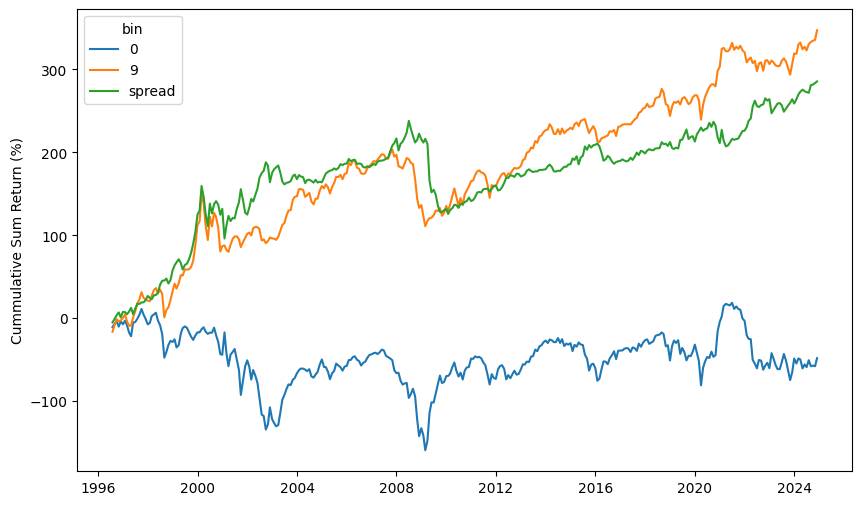

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

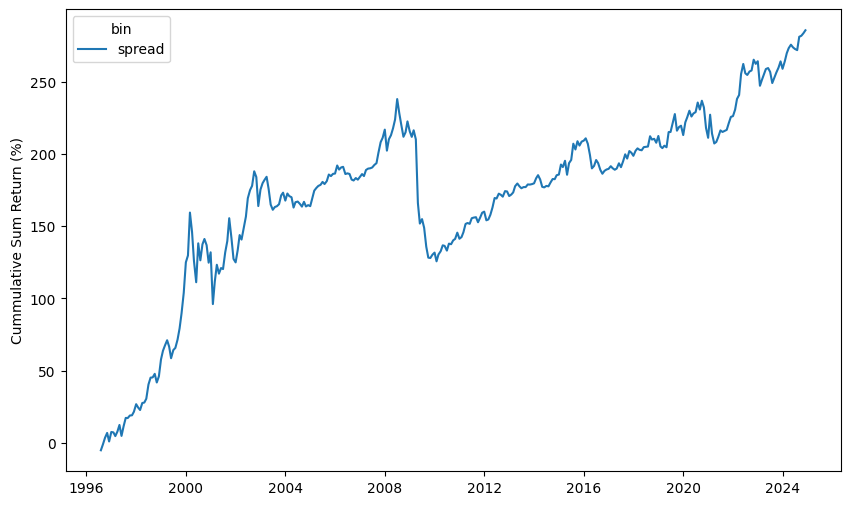

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [15]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 1996-07-31 to 2024-11-29
